## Home Credit Default Risk
#### Models Implemented in this Notebook: Light GBM and XGBoost with 6 new features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [4]:
print('Train data set: ', app_train.shape)
print('Test data set: ', app_test.shape)

Train data set:  (307511, 122)
Test data set:  (48744, 121)


In [5]:
y_train = app_train[['TARGET']]

In [6]:
y_train.shape

(307511, 1)

In [7]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [8]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [9]:
# Missing data analysis
def missing_values(df):
    '''
    Calculate the number and % of missing values for each column of dataframe
    '''
    missing_count = df.isnull().sum()
    missing_percent = df.isnull().sum()/len(df) *100
    
    # Store these values to a new df
    missing_val_df = pd.concat([missing_count, missing_percent], axis =1)
    missing_val_df.rename({0 : 'missing_count', 1: 'missing_percent'}, axis =1, inplace = True)
    missing_val_df.sort_values('missing_percent', inplace= True, ascending = False)
    missing_val_df = missing_val_df[missing_val_df.missing_count != 0]
    print('Number of columns with missing values are: ', missing_val_df.shape[0])
    
    return missing_val_df

In [10]:
missing_val_df = missing_values(app_train)
print(missing_val_df.head())

Number of columns with missing values are:  67
                          missing_count  missing_percent
COMMONAREA_MEDI                  214865        69.872297
COMMONAREA_AVG                   214865        69.872297
COMMONAREA_MODE                  214865        69.872297
NONLIVINGAPARTMENTS_MODE         213514        69.432963
NONLIVINGAPARTMENTS_AVG          213514        69.432963


In [11]:
# Number of columns of each data type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
# Let's look at the number of unique entries in each of the object (categorical) columns.
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
# Using Label Encoding for any categorical variables with only 2 categories and 
# One-Hot Encoding for any categorical variables with more than 2 categories
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
le_count = 0
cat_columns = []

In [14]:
for col in app_train:
    if app_train[col].dtype == 'object' and app_train[col].unique().shape[0] <= 2:
        # Train on training data
        label_encoder.fit(app_train[col])
        # Transform both training and testing data
        app_train[col] = label_encoder.transform(app_train[col])
        app_test[col] = label_encoder.transform(app_test[col])
        
        # Number of columns label transformed
        le_count += 1
        cat_columns.append(col)
print('%d columns were label encoded.' % le_count)
print('Categorical columns: ', cat_columns)

3 columns were label encoded.
Categorical columns:  ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [15]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [16]:
# one-hot encoding of categorical variables
original_cols = app_train.columns
print(original_cols)
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [17]:
new_columns = app_train.columns
for col in new_columns:
    if col not in original_cols:
        cat_columns.append(col)
#print('Categorical Columns:\n ', cat_columns)

In [18]:
print('Number of Categorical Columns: ', len(cat_columns))

Number of Categorical Columns:  137


In [19]:
y_train = app_train['TARGET']

In [20]:
# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

In [21]:
for col in cat_columns:
    if col not in app_train.columns:
        cat_columns.remove(col)
print('Number of Categorical Columns: ', len(cat_columns))

Number of Categorical Columns:  134


In [22]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


In [23]:
## Correlation Among Features
app_train['TARGET'] = y_train

# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations: \n', correlations.tail(15))
print('\nMost Negative Correlations: \n', correlations.head(15))

Most Positive Correlations: 
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negat

In [24]:
def new_features(df):
    df['credit_to_annuity'] = df['AMT_CREDIT']/df['AMT_ANNUITY']
    df['credit_to_good'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['credit_to_income'] = df['AMT_CREDIT']/ (1+ df['AMT_INCOME_TOTAL'])
    df['annuity_to_income'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    #inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    #df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['num_days_employed_to_birth'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ext_sources_mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

    return df

In [25]:
train = new_features(app_train)
test = new_features(app_test)
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 246)
Testing Features shape:  (48744, 245)


In [26]:
app_train = train.copy()
app_test = test.copy()

In [27]:
# preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling)
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 245)
Testing data shape:  (48744, 245)


In [28]:
# Logistic regression Model
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, y_train)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [29]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\Users\sneha\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,SK_ID_CURR,TARGET
0,100001,0.064773
1,100005,0.129571
2,100013,0.080235
3,100028,0.059584
4,100038,0.132523


In [30]:
submit.to_csv('log_reg_6_new.csv', index = False)

In [31]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 200, random_state = 50)

In [32]:
# Train on the training data
random_forest.fit(train, y_train)

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [33]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_6_new.csv', index = False)

C:\Users\sneha\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [34]:
## Feature Importances
def show_feature_imp(model, features):
    plt.figure(figsize = (12, 8))
    
    # DF of feature importances sorted from most to least
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending = False)
    
    # Display
    print(results.head(10))
    print('\nNumber of features with importance greater than 0.01 = ', np.sum(results['importance'] > 0.01))
    
    # Plot of feature importances as horizontal bar chart
    results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                     color = 'red', edgecolor = 'k', title = 'Feature Importances');
    return results

                        feature  importance
244            ext_sources_mean    0.049316
32                 EXT_SOURCE_2    0.036859
33                 EXT_SOURCE_3    0.035073
10                   DAYS_BIRTH    0.026305
13              DAYS_ID_PUBLISH    0.026261
12            DAYS_REGISTRATION    0.025731
243  num_days_employed_to_birth    0.025627
239           credit_to_annuity    0.025154
0                    SK_ID_CURR    0.025103
242           annuity_to_income    0.024787

Number of features with importance greater than 0.01 =  25


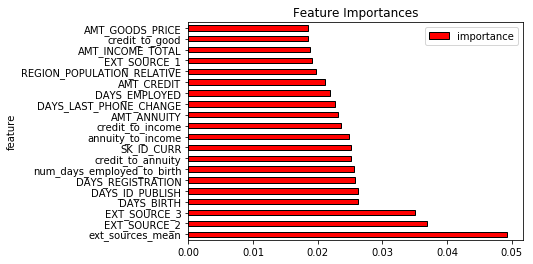

In [35]:
# Show the feature importances for the default features
feature_importances = show_feature_imp(random_forest, features)

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import gc

# Format the training and testing data 
if 'TARGET' in app_train:
    train = np.array(app_train.drop(columns = 'TARGET'))
else:
    train = np.array(app_train)
test = np.array(app_test)

train_labels = np.array(y_train).reshape((-1, ))

# 10 fold cross validation
folds = KFold(n_splits=5, shuffle=True, random_state=50)

# Validation and test predictions
valid_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])

# Iterate through each fold
for n_fold, (train_indices, valid_indices) in enumerate(folds.split(train)):
    # Training data for the fold
    train_fold, train_fold_labels = train[train_indices, :], train_labels[train_indices]
    
    # Validation data for the fold
    valid_fold, valid_fold_labels = train[valid_indices, :], train_labels[valid_indices]
    
    # LightGBM classifier with hyperparameters
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.1,
        subsample=.8,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )
    
    # Fit on the training data, evaluate on the validation data
    clf.fit(train_fold, train_fold_labels, 
            eval_set= [(train_fold, train_fold_labels), (valid_fold, valid_fold_labels)], 
            eval_metric='auc', early_stopping_rounds=100, verbose = False
           )
    
    # Validation preditions
    valid_preds[valid_indices] = clf.predict_proba(valid_fold, num_iteration=clf.best_iteration_)[:, 1]
    
    # Testing predictions
    test_preds += clf.predict_proba(test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # Display the performance for the current fold
    print('Fold %d AUC : %0.6f' % (n_fold + 1, roc_auc_score(valid_fold_labels, valid_preds[valid_indices])))
    
    # Delete variables to free up memory
   # del clf, train_fold, train_fold_labels, valid_fold, valid_fold_labels
   # gc.collect()
    

# Make a submission dataframe
submission = app_test[['SK_ID_CURR']]
submission['TARGET'] = test_preds

# Save the submission file
submission.to_csv("light_gbm_6_new_feat.csv", index=False)

Fold 1 AUC : 0.762867
Fold 2 AUC : 0.766437
Fold 3 AUC : 0.770810
Fold 4 AUC : 0.764950
Fold 5 AUC : 0.766020


C:\Users\sneha\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
print(len(clf.feature_importances_))
cols = app_train.drop(columns = 'TARGET')

print(len(cols.columns))


245
245


                    feature  importance
239       credit_to_annuity         480
33             EXT_SOURCE_3         335
244        ext_sources_mean         309
10               DAYS_BIRTH         270
31             EXT_SOURCE_1         241
240          credit_to_good         217
32             EXT_SOURCE_2         213
7               AMT_ANNUITY         178
13          DAYS_ID_PUBLISH         175
81   DAYS_LAST_PHONE_CHANGE         156

Number of features with importance greater than 0.01 =  191


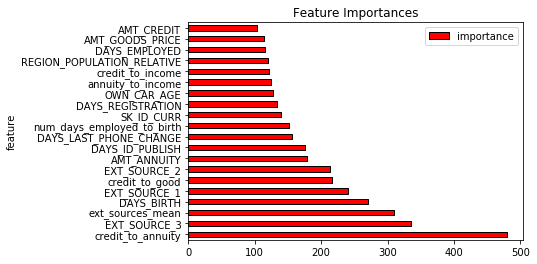

In [44]:
importance_df = pd.DataFrame()
importance_df["feature"] = cols.columns
importance_df["importance"] = clf.feature_importances_
results = importance_df.sort_values('importance', ascending = False)
 
# Display
print(results.head(10))
print('\nNumber of features with importance greater than 0.01 = ', np.sum(results['importance'] > 0.01))

# Plot of feature importances as horizontal bar chart
results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                 color = 'red', edgecolor = 'k', title = 'Feature Importances');

In [ ]:
# XGBoost
from xgboost import XGBClassifier

# Validation and test predictions
valid_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

# Iterate through each fold
for n_fold, (train_indices, valid_indices) in enumerate(folds.split(train)):
    # Training data for the fold
    train_fold, train_fold_labels = train[train_indices, :], train_labels[train_indices]
    
    # Validation data for the fold
    valid_fold, valid_fold_labels = train[valid_indices, :], train_labels[valid_indices]
    
    # XGBoost classifier with hyperparameters
    xgb_clf = XGBClassifier(
        n_estimators=10000,
        learning_rate=0.01,
        subsample=.8,
        colsample_bytree=0.8,
        max_depth=4,
        min_child_weight=4,
        objective= 'binary:logistic',
        #nthread=4,
        scale_pos_weight=2,
        seed=27
    )
  
    
    # Fit on the training data, evaluate on the validation data
    xgb_clf.fit(train_fold, train_fold_labels, 
            eval_set= [(train_fold, train_fold_labels), (valid_fold, valid_fold_labels)], 
            eval_metric='auc', early_stopping_rounds=200, verbose = False
           )
    
    # Validation preditions
    valid_preds[valid_indices] = xgb_clf.predict_proba(valid_fold, num_iteration=clf.best_iteration_)[:, 1]
    
    # Testing predictions
    test_preds += xgb_clf.predict_proba(test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # Display the performance for the current fold
    print('Fold %d AUC : %0.6f' % (n_fold + 1, roc_auc_score(valid_fold_labels, valid_preds[valid_indices])))
    
    
    
importance_df = pd.DataFrame()
importance_df["feature"] = cols.columns
importance_df["importance"] = xgb_clf.feature_importances_
results = importance_df.sort_values('importance', ascending = False)
    
# Display
print(results.head(10))
print('\nNumber of features with importance greater than 0.01 = ', np.sum(results['importance'] > 0.01))

# Plot of feature importances as horizontal bar chart
results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                 color = 'red', edgecolor = 'k', title = 'Feature Importances')

# Make a submission dataframe
submission = app_test[['SK_ID_CURR']]
submission['TARGET'] = test_preds

# Save the submission file
submission.to_csv("xgb_gbm_6_new_feat.csv", index=False)

# Delete variables to free up memory
del train_fold, train_fold_labels, valid_fold, valid_fold_labels
gc.collect()